In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/22.23\ Sem\ B/CS4486\ Artificial\ Intelligence/HW3

/content/gdrive/MyDrive/22.23 Sem B/CS4486 Artificial Intelligence/HW3


In [3]:
pwd

'/content/gdrive/MyDrive/22.23 Sem B/CS4486 Artificial Intelligence/HW3'

In [4]:
ls -l './Topic_5_Data/ISIC84by84/Train'

total 32
drwx------ 2 root root 4096 Sep 18  2022 AK/
drwx------ 2 root root 4096 Sep 18  2022 BCC/
drwx------ 2 root root 4096 Sep 18  2022 BKL/
drwx------ 2 root root 4096 Sep 18  2022 DF/
drwx------ 2 root root 4096 Sep 18  2022 MEL/
drwx------ 2 root root 4096 Sep 18  2022 NV/
drwx------ 2 root root 4096 Sep 18  2022 SCC/
drwx------ 2 root root 4096 Sep 18  2022 VASC/


In [5]:
import os

EDA

In [6]:
dataroot = './Topic_5_Data/ISIC84by84'

In [7]:
# labels = [name for name in os.listdir(dataroot+'/Train') if os.path.isdir(name)]
labels = os.listdir(dataroot+'/Train')
print(labels)

['AK', 'BCC', 'DF', 'BKL', 'MEL', 'SCC', 'NV', 'VASC']


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
import pathlib
train_data_dir = pathlib.Path(dataroot+'/Train')
for i in range(len(labels)):
  image_count = len(list(train_data_dir.glob(labels[i]+'/*.jpg')))
  print(labels[i],':',image_count)


AK : 735
BCC : 3223
DF : 139
BKL : 2524
MEL : 4422
SCC : 528
NV : 12775
VASC : 153


In [10]:
test_data_dir = pathlib.Path(dataroot+'/Test')
for i in range(len(labels)):
  image_count = len(list(test_data_dir.glob(labels[i]+'/*.jpg')))
  print(labels[i],':',image_count)

AK : 100
BCC : 100
DF : 100
BKL : 100
MEL : 100
SCC : 100
NV : 100
VASC : 100


In [11]:
train_data_ak = list(train_data_dir.glob('AK/*'))
PIL.Image.open(str(train_data_ak[0]))
print(PIL.Image.open(str(train_data_ak[10])).size)

(84, 84)


In [12]:
batch_size = 32
img_h = 84
img_w = 84

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_h, img_w),
  batch_size=batch_size)

Found 24499 files belonging to 8 classes.
Using 19600 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_h, img_w),
  batch_size=batch_size)

Found 24499 files belonging to 8 classes.
Using 4899 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [16]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 84, 84, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

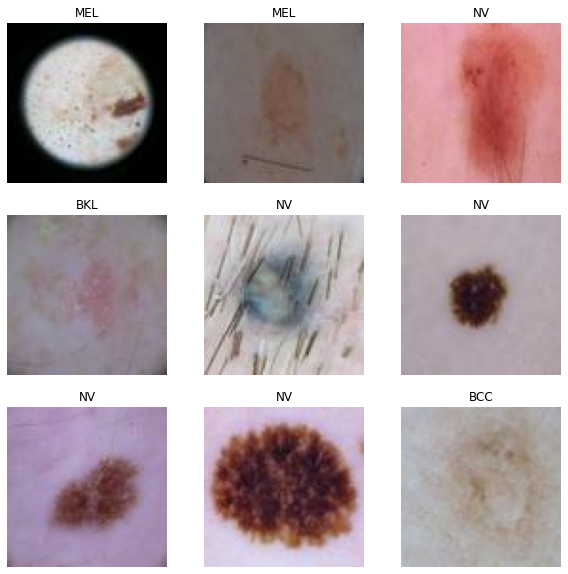

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 84, 84, 3)
(32,)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalization

In [20]:
normalization_layer = layers.Rescaling(1./255)

In [21]:

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.8470589


Create model

In [23]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_h, img_w, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 84, 84, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 84, 84, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        1

Model training

In [26]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
613/613 [==============================] - 1598s 3s/step - loss: 1.1835 - accuracy: 0.5698 - val_loss: 1.0801 - val_accuracy: 0.6113
Epoch 2/10
613/613 [==============================] - 4s 7ms/step - loss: 1.0628 - accuracy: 0.6161 - val_loss: 1.0801 - val_accuracy: 0.6230
Epoch 3/10
613/613 [==============================] - 5s 7ms/step - loss: 1.0176 - accuracy: 0.6289 - val_loss: 1.0023 - val_accuracy: 0.6346
Epoch 4/10
613/613 [==============================] - 4s 6ms/step - loss: 0.9656 - accuracy: 0.6470 - val_loss: 0.9886 - val_accuracy: 0.6393
Epoch 5/10
613/613 [==============================] - 4s 6ms/step - loss: 0.9234 - accuracy: 0.6631 - val_loss: 0.9804 - val_accuracy: 0.6465
Epoch 6/10
613/613 [==============================] - 5s 7ms/step - loss: 0.8844 - accuracy: 0.6753 - val_loss: 0.9326 - val_accuracy: 0.6628
Epoch 7/10
613/613 [==============================] - 4s 7ms/step - loss: 0.8383 - accuracy: 0.6927 - val_loss: 0.9507 - val_accuracy: 0.6605
Epoc

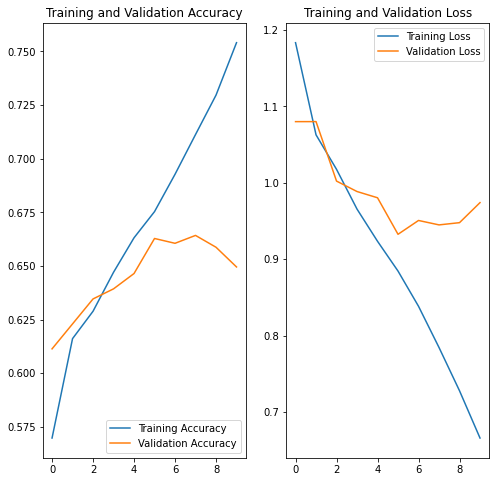

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_h,
                                  img_w,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

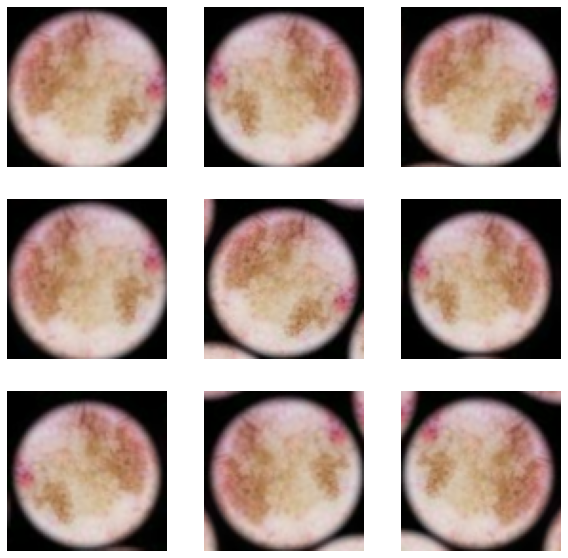

In [29]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [30]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 84, 84, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 84, 84, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 42, 42, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 42, 42, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 32)       0         
 2D)                                                  

In [33]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


613/613 [==============================] - 81s 126ms/step - loss: 1.2185 - accuracy: 0.5588 - val_loss: 1.1232 - val_accuracy: 0.6024
Epoch 2/20
613/613 [==============================] - 75s 122ms/step - loss: 1.1080 - accuracy: 0.5957 - val_loss: 1.0619 - val_accuracy: 0.6189
Epoch 3/20
613/613 [==============================] - 76s 124ms/step - loss: 1.0649 - accuracy: 0.6105 - val_loss: 1.0360 - val_accuracy: 0.6265
Epoch 4/20
613/613 [==============================] - 75s 122ms/step - loss: 1.0304 - accuracy: 0.6239 - val_loss: 1.0077 - val_accuracy: 0.6332
Epoch 5/20
613/613 [==============================] - 75s 123ms/step - loss: 1.0058 - accuracy: 0.6308 - val_loss: 1.0007 - val_accuracy: 0.6342
Epoch 6/20
613/613 [==============================] - 76s 124ms/step - loss: 0.9851 - accuracy: 0.6355 - val_loss: 0.9706 - val_accuracy: 0.6465
Epoch 7/20
613/613 [==============================] - 74s 121ms/step - loss: 0.9692 - accuracy: 0.6445 - val_loss: 0.9669 - val_accuracy: 0.6

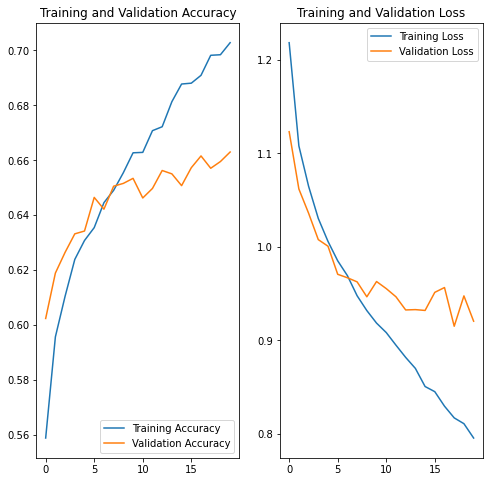

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  initial_epoch=history.epoch[-1]
)

Epoch 20/100
613/613 [==============================] - 80s 131ms/step - loss: 0.7924 - accuracy: 0.7071 - val_loss: 0.9430 - val_accuracy: 0.6530
Epoch 21/100
613/613 [==============================] - 79s 128ms/step - loss: 0.7851 - accuracy: 0.7072 - val_loss: 0.9280 - val_accuracy: 0.6587
Epoch 22/100
613/613 [==============================] - 76s 124ms/step - loss: 0.7611 - accuracy: 0.7147 - val_loss: 0.9316 - val_accuracy: 0.6612
Epoch 23/100
613/613 [==============================] - 77s 125ms/step - loss: 0.7544 - accuracy: 0.7208 - val_loss: 0.9628 - val_accuracy: 0.6573
Epoch 24/100
613/613 [==============================] - 76s 124ms/step - loss: 0.7552 - accuracy: 0.7189 - val_loss: 0.9407 - val_accuracy: 0.6689
Epoch 25/100
613/613 [==============================] - 75s 123ms/step - loss: 0.7440 - accuracy: 0.7236 - val_loss: 0.9270 - val_accuracy: 0.6677
Epoch 26/100
613/613 [==============================] - 77s 125ms/step - loss: 0.7227 - accuracy: 0.7280 - val_loss: 0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-37-ab192aeb141e>", line 11, in <module>
    plt.plot(epochs_range, acc, label='Training Accuracy')
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py", line 2812, in plot
    return gca().plot(
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/axes/_axes.py", line 1688, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
  File "/usr/local/lib/python3.9/dist-packages/matplotlib/axes/_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
ValueError: x and y must have same first dimension, but have shapes (100,) and (81,)

During handling of the above exception,

ValueError: ignored

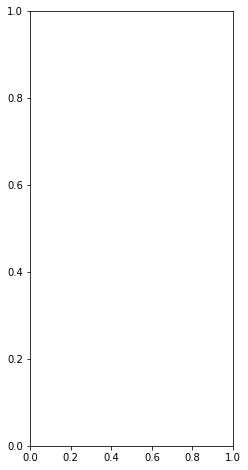

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()